In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense
from keras.models import Sequential
import keras
from texttable import Texttable
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 50
BATCH_SIZE = 16

In [3]:
def get_Data(data):

    TargetVariable = ['CPU Package Temperature']
    Predictors = ["CPU Total","RAM","Disk Temperature","Used Space","Power CPU Package","Power CPU Cores","Power CPU Graphics","Power CPU DRAM" ]

    X = data[Predictors].values
    y = data[TargetVariable].values

    PredictorScaler = StandardScaler()
    TargetVarScaler = StandardScaler()

    PredictorScalerFit = PredictorScaler.fit(X)
    TargetVarScalerFit = TargetVarScaler.fit(y)

    X = PredictorScalerFit.transform(X)
    y = TargetVarScalerFit.transform(y)


    return X,y,PredictorScalerFit,TargetVarScalerFit

In [4]:
def SplitData(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
    return X_train,X_test,y_train,y_test

In [5]:
def SplitData_(data):
    ds=data.drop(columns='CPU Package Temperature')
    X=ds.iloc[::].values
    Y=data.iloc[:,1].values
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    return X_train,X_test,Y_train,Y_test

In [6]:
def Get_Model(INPUT_DIM):

    model = Sequential()

    model.add(Dense(64, activation='relu', input_dim=INPUT_DIM))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1,activation='linear'))
    model.compile(optimizer='adam', loss='mse',metrics=['mse','mae'])

    print(model.summary())

    return model

In [7]:
def accuracy(X_test,y_test,PredictorScalerFit,TargetVarScalerFit,table_data):
    model = keras.models.load_model('data/model.h5')

    Predictions = model.predict(X_test)
    Predictions = TargetVarScalerFit.inverse_transform(Predictions)

    y_test_orig = TargetVarScalerFit.inverse_transform(y_test)

    Test_Data = PredictorScalerFit.inverse_transform(X_test)
    score=model.evaluate(X_test,y_test,verbose=0)

    colums = []
    colums.append("Artificial Neural Network")
    colums.append(score[0])

    absolute_percentage_errors = 100 * (abs(y_test_orig - Predictions) / y_test_orig)
    colums.append(str(round(100 - np.mean(absolute_percentage_errors),2))+"%")

    table_data.append(colums)

In [8]:
def Train_Model():

    data = pd.read_csv("data/train_data.csv")

    X,y,PredictorScalerFit,TargetVarScalerFit = get_Data(data)

    X_train,X_test,y_train,y_test=SplitData(X,y)

    INPUT_DIM = X_train.shape[1]
    model = Get_Model(INPUT_DIM)

    history=model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=1)

    model.save("data/model.h5")

    return X_test,y_test,PredictorScalerFit,TargetVarScalerFit,history

In [9]:
def Predict(X,PredictorScalerFit,TargetVarScalerFit):

    model = keras.models.load_model('data/model.h5')

    X = PredictorScalerFit.transform(X)

    Predicted_temperature=model.predict(X)

    X=PredictorScalerFit.inverse_transform(X)

    Predicted_temperature=TargetVarScalerFit.inverse_transform(Predicted_temperature)

    print("Predicted CPU Temperature : ",Predicted_temperature[0][0])

In [10]:
def ANN(table_data):

    X_test,y_test,PredictorScalerFit,TargetVarScalerFit,history = Train_Model()

    accuracy(X_test,y_test, PredictorScalerFit, TargetVarScalerFit,table_data)

    return PredictorScalerFit,TargetVarScalerFit,history

In [11]:
def train_model_RandomForestRegressor(X_train,Y_train):
    regressor = RandomForestRegressor(n_estimators=1000,random_state=1)
    regressor.fit(X_train,Y_train)
    return regressor

In [12]:
def train_model_gradient_boosting(X_train,Y_train):
    regressor=GradientBoostingRegressor(n_estimators=500,random_state=1)
    regressor.fit(X_train,Y_train)
    return regressor

In [13]:
def result(model,X_test,Y_test,colums):
    Predictions=model.predict(X_test)
    colums.append(mean_squared_error(Y_test,Predictions))
    colums.append(str(round(model.score(X_test,Y_test)*100,2))+"%")

In [14]:
def Random_Forest(table_data,X_train, X_test, Y_train, Y_test):
    colums=[]
    colums.append("Random Forest")
    model_RandomForestRegressor = train_model_RandomForestRegressor(X_train, Y_train)
    result(model_RandomForestRegressor, X_test, Y_test, colums)
    table_data.append(colums)

In [15]:
def Gradient_Boosting_Regressor(table_data,X_train, X_test, Y_train, Y_test):
    colums = []
    colums.append("Gradient Boosting Regressor")
    model_gradient_boosting = train_model_gradient_boosting(X_train, Y_train)
    result(model_gradient_boosting, X_test, Y_test, colums)
    table_data.append(colums)

In [16]:
def plot_result(history):
    plt.title('Loss / Mean Squared Error')
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(mse)')
    plt.legend()
    plt.show()

    plt.title('Mean Absolute Error')
    plt.plot(history.history['mae'], label='training mae')
    plt.plot(history.history['val_mae'], label='validation mae')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
875/875 [==============================] - 1s 2ms/step - loss: 0.3690 - mse: 0.3690 - mae: 0.4741 - val_loss: 0.3495 - val_mse: 0.3495 - val_mae: 0.4635
Epoch 2/50
875/875 [==============================] - 1s 1ms/step - loss: 0.3318 - 

875/875 [==============================] - 1s 2ms/step - loss: 0.2198 - mse: 0.2198 - mae: 0.3623 - val_loss: 0.2483 - val_mse: 0.2483 - val_mae: 0.3819
Epoch 46/50
875/875 [==============================] - 1s 2ms/step - loss: 0.2180 - mse: 0.2180 - mae: 0.3618 - val_loss: 0.2409 - val_mse: 0.2409 - val_mae: 0.3795
Epoch 47/50
875/875 [==============================] - 1s 2ms/step - loss: 0.2197 - mse: 0.2197 - mae: 0.3622 - val_loss: 0.2376 - val_mse: 0.2376 - val_mae: 0.3761
Epoch 48/50
875/875 [==============================] - 1s 2ms/step - loss: 0.2179 - mse: 0.2179 - mae: 0.3594 - val_loss: 0.2409 - val_mse: 0.2409 - val_mae: 0.3800
Epoch 49/50
875/875 [==============================] - 2s 2ms/step - loss: 0.2147 - mse: 0.2147 - mae: 0.3568 - val_loss: 0.2423 - val_mse: 0.2423 - val_mae: 0.3756
Epoch 50/50
875/875 [==============================] - 2s 2ms/step - loss: 0.2145 - mse: 0.2145 - mae: 0.3573 - val_loss: 0.2452 - val_mse: 0.2452 - val_mae: 0.3813
+---------------------

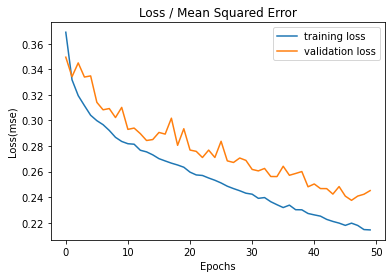

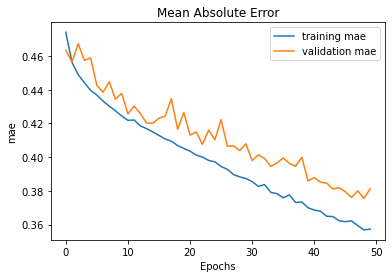

In [17]:
table_data = [["Model", "Mean Squared Error", "Accuracy"]]

data = pd.read_csv("data/train_data.csv")
X_train,X_test,Y_train,Y_test = SplitData_(data)


PredictorScalerFit,TargetVarScalerFit,history=ANN(table_data)
Random_Forest(table_data,X_train,X_test,Y_train,Y_test)
Gradient_Boosting_Regressor(table_data,X_train,X_test,Y_train,Y_test)

table = Texttable()
table.add_rows(table_data)
print(table.draw())

plot_result(history)